<a href="https://colab.research.google.com/github/cboyda/MachineLearning/blob/main/PA4_Team1_W23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Assignment #4: Decision Tree**

Team member names:

*  Brett Adams
*  Cailenys Leslie
*  Clinton Boyda 
*  Tanvir Hossain
*  Ram Dershan

Dataset: 
[New York City Airbnb Open Data](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data)

In [419]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import model_selection
from  sklearn import neighbors
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [420]:
# Connect to Dataset

#original filename = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/AB_NYC_2019.csv"
#df = pd.read_csv(filename)

# load both data sets in
original = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/AB_NYC_2019.csv"
df_original = pd.read_csv(original)
additional = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/full_nyc_dataset_cleaned_table-1.csv"
df_additional = pd.read_csv(additional)

In [421]:
# Merge the two datasets with an inner join, validate that no duplicate id values exist for a one to one join
df = pd.merge(df_original, df_additional, how = "inner", on = "id", validate="one_to_one", suffixes=("_original","_additional"))
df.shape

(16005, 22)

In [422]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type_original', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'property_type', 'room_type_additional',
       'accommodates', 'bathrooms_text', 'bedrooms', 'beds'],
      dtype='object')

# **Data Cleaning**

In [423]:
# check value counts for property_type
df['property_type'].value_counts()

Entire rental unit                    6975
Private room in rental unit           5153
Private room in home                   844
Entire home                            513
Entire condo                           418
Private room in townhouse              352
Entire loft                            326
Entire townhouse                       297
Private room in condo                  180
Shared room in rental unit             178
Private room in loft                   149
Entire guest suite                     133
Entire serviced apartment               98
Room in boutique hotel                  68
Room in hotel                           56
Private room in guest suite             37
Entire place                            33
Room in serviced apartment              24
Shared room in loft                     19
Entire guesthouse                       19
Private room                            18
Private room in resort                  17
Private room in bed and breakfast       14
Shared room

There are property types that we do not want to consider in our analysis (Boats, Caves and Villa's) so we will remove these examples.

In [424]:
# Check shape before dropping examples
df.shape

(16005, 22)

In [425]:
df = df.drop(df[(df['property_type'] == 'Cave') | (df['property_type'] == 'Boat') | 
                (df['property_type'] == 'Floor') | (df['property_type'] == 'Private room in farm stay') |
                (df['property_type'] == 'Entire villa') | (df['property_type'] == 'Private room in houseboat') |
                (df['property_type'] == 'Private room in villa') | (df['property_type'] == 'Private room in tent') |
                (df['property_type'] == 'Houseboat')].index)

In [426]:
# Check shape after dropping examples
df.shape

(15986, 22)

In [427]:
# assess new value counts for property_type
df['property_type'].value_counts()

Entire rental unit                    6975
Private room in rental unit           5153
Private room in home                   844
Entire home                            513
Entire condo                           418
Private room in townhouse              352
Entire loft                            326
Entire townhouse                       297
Private room in condo                  180
Shared room in rental unit             178
Private room in loft                   149
Entire guest suite                     133
Entire serviced apartment               98
Room in boutique hotel                  68
Room in hotel                           56
Private room in guest suite             37
Entire place                            33
Room in serviced apartment              24
Entire guesthouse                       19
Shared room in loft                     19
Private room                            18
Private room in resort                  17
Private room in bed and breakfast       14
Shared room

In [428]:
# extract the numerical values from the bathroom_text column for consideration 
df['bathrooms_text'].mask(df['bathrooms_text'] == 'Half-bath', 0.5, inplace=True)
df['bathrooms_text'].mask(df['bathrooms_text'] == 'Shared half-bath', 0.5, inplace=True)
df['bathrooms_text'].mask(df['bathrooms_text'] == 'Private half-bath', 0.5, inplace=True)
df['bathrooms'] = df['bathrooms_text'].str.extract(r'\b([\d.]+)\b')

In [429]:
# let's look closer at the property_type values, perhaps this can be simplified
print(df['property_type'].unique())
print("Number of property_type unique values:",df['property_type'].nunique())

['Entire rental unit' 'Private room in rental unit'
 'Private room in townhouse' 'Entire guest suite' 'Entire loft'
 'Private room in home' 'Entire condo' 'Private room in condo'
 'Private room in loft' 'Entire home' 'Entire townhouse'
 'Private room in bed and breakfast' 'Entire guesthouse'
 'Private room in guest suite' 'Room in boutique hotel'
 'Shared room in rental unit' 'Shared room in home' 'Private room'
 'Entire place' 'Entire serviced apartment' 'Private room in guesthouse'
 'Room in serviced apartment' 'Entire cottage' 'Shared room in loft'
 'Private room in serviced apartment' 'Entire bungalow' 'Room in hotel'
 'Shared room in townhouse' 'Private room in hostel'
 'Private room in bungalow' 'Shared room in condo'
 'Private room in resort' 'Shared room in floor' 'Private room in floor'
 'Tiny home' 'Entire home/apt' 'Shared room in guest suite'
 'Room in resort' 'Room in aparthotel' 'Shared room in guesthouse'
 'Room in bed and breakfast']
Number of property_type unique value

In [430]:
df['property_type'] = df.property_type.str.replace(r'(^.*Private room.*$)', 'Private Room')
#df.property_type.replace(['Private room in rental unit', 'female'], [1, 0], inplace=True)
#replace_property_values = {'Small' : 1, 'Medium' : 2, 'High' : 3 }
#replace_property_values = df.loc[df['property_type'].str.contains('Private room', case=False), 'property_type'] = 'Private Room'

In [431]:
df['property_type'] = df.property_type.str.replace(r'(^.*Entire.*$)', 'Entire Unit')

In [432]:
df['property_type'] = df.property_type.str.replace(r'(^.*Shared room.*$)', 'Shared Room')

In [433]:
df['property_type'] = df.property_type.str.replace(r'(^.*Room in.*$)', 'Room In')

In [434]:
print(df['property_type'].unique())
print("Number of property_type unique values:",df['property_type'].nunique())

['Entire Unit' 'Private Room' 'Room In' 'Shared Room' 'Tiny home']
Number of property_type unique values: 5


In [435]:
# Convert bathroom to float type
df['bathrooms'] = df['bathrooms'].astype(float)

In [436]:
# drop bathroom_text, beds, and duplicated room_type column
df.drop(['bathrooms_text', 'room_type_additional', 'beds'], axis = 1, inplace = True)

In [437]:
# drop suffix from room_type_original
df = df.rename(columns = {'room_type_original' : 'room_type'})

In [438]:
# check for null values
df.isnull().sum()

id                                   0
name                                11
host_id                              0
host_name                           10
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       3010
reviews_per_month                 3010
calculated_host_listings_count       0
availability_365                     0
property_type                        0
accommodates                         0
bedrooms                          1562
bathrooms                           52
dtype: int64

For bedrooms and bathrooms with null values, fill with zero as properties can have no bedrooms or bathrooms

In [439]:
df[['bedrooms', 'bathrooms']] = df[['bedrooms', 'bathrooms']].fillna(value=0)

In [440]:
# Check null values again to confirm
df.isnull().sum()

id                                   0
name                                11
host_id                              0
host_name                           10
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       3010
reviews_per_month                 3010
calculated_host_listings_count       0
availability_365                     0
property_type                        0
accommodates                         0
bedrooms                             0
bathrooms                            0
dtype: int64

All other columns with null values are not important for this analysis as these columns will be dropped.

# **Feature Scaling**


In [441]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'property_type', 'accommodates', 'bedrooms',
       'bathrooms'],
      dtype='object')

In [442]:
# drop all columns not necessary
# over simplifying for our first iteration

df.drop(['neighbourhood','name','host_name','number_of_reviews','last_review','reviews_per_month',
         'calculated_host_listings_count','id','host_id','latitude','longitude'], axis=1, inplace = True)
# df.drop('a', inplace=True, axis=1)

In [443]:
#define clean as duplicate
df_clean = df.copy()

In [444]:
df_clean

,neighbourhood_group,room_type,price,minimum_nights,availability_365,property_type,accommodates,bedrooms,bathrooms
0,Manhattan,Entire home/apt,225,1,355,Entire Unit,1,0.0,1.0
1,Brooklyn,Private room,60,45,0,Private Room,2,1.0,0.0
2,Manhattan,Private room,79,2,220,Private Room,2,1.0,1.0
3,Manhattan,Private room,79,2,0,Private Room,1,1.0,1.0
4,Brooklyn,Private room,89,4,314,Private Room,2,1.0,1.5
...,...,...,...,...,...,...,...,...,...
16000,Queens,Entire home/apt,85,3,300,Entire Unit,2,1.0,1.0
16001,Manhattan,Private room,95,1,2,Private Room,2,1.0,1.0
16002,Brooklyn,Entire home/apt,170,1,363,Entire Unit,6,2.0,1.0
16003,Brooklyn,Private room,54,6,15,Private Room,2,1.0,1.0


In [445]:
zero_availability = df_clean.loc[df_clean.availability_365 == 0, 'availability_365'].index
# zero availability means unit is NOT available so best drop from out model
df_clean.drop(zero_availability,axis=0,inplace=True)

DROP units that are simply not able to be rented. This includes availability = 0

In [446]:
# dropping availability_365 feature at this stage since it was a filter not a feature
df_clean.drop(['availability_365'], axis=1, inplace = True)

In [447]:
df_clean.shape

(8624, 8)

In [448]:
numeric_data = df_clean.select_dtypes(include=[np.number])
categorical_data = df_clean.select_dtypes(exclude=[np.number])

In [449]:
numeric_data

,price,minimum_nights,accommodates,bedrooms,bathrooms
0,225,1,1,0.0,1.0
2,79,2,2,1.0,1.0
4,89,4,2,1.0,1.5
5,140,2,3,0.0,1.0
6,215,2,4,1.0,1.0
...,...,...,...,...,...
16000,85,3,2,1.0,1.0
16001,95,1,2,1.0,1.0
16002,170,1,6,2.0,1.0
16003,54,6,2,1.0,1.0


In [450]:
categorical_data

,neighbourhood_group,room_type,property_type
0,Manhattan,Entire home/apt,Entire Unit
2,Manhattan,Private room,Private Room
4,Brooklyn,Private room,Private Room
5,Brooklyn,Entire home/apt,Entire Unit
6,Brooklyn,Entire home/apt,Entire Unit
...,...,...,...
16000,Queens,Entire home/apt,Entire Unit
16001,Manhattan,Private room,Private Room
16002,Brooklyn,Entire home/apt,Entire Unit
16003,Brooklyn,Private room,Private Room


In [451]:
df_clean

,neighbourhood_group,room_type,price,minimum_nights,property_type,accommodates,bedrooms,bathrooms
0,Manhattan,Entire home/apt,225,1,Entire Unit,1,0.0,1.0
2,Manhattan,Private room,79,2,Private Room,2,1.0,1.0
4,Brooklyn,Private room,89,4,Private Room,2,1.0,1.5
5,Brooklyn,Entire home/apt,140,2,Entire Unit,3,0.0,1.0
6,Brooklyn,Entire home/apt,215,2,Entire Unit,4,1.0,1.0
...,...,...,...,...,...,...,...,...
16000,Queens,Entire home/apt,85,3,Entire Unit,2,1.0,1.0
16001,Manhattan,Private room,95,1,Private Room,2,1.0,1.0
16002,Brooklyn,Entire home/apt,170,1,Entire Unit,6,2.0,1.0
16003,Brooklyn,Private room,54,6,Private Room,2,1.0,1.0


In [452]:
# any null values? 0 means none found == no need to fix nulls
df_clean.isna().sum()

neighbourhood_group    0
room_type              0
price                  0
minimum_nights         0
property_type          0
accommodates           0
bedrooms               0
bathrooms              0
dtype: int64

In [453]:
# what are the unique values for each column?
# label can be category but others should be binary for simplicity
for col in df_clean:
    print(col, df_clean[col].unique(), df_clean[col].nunique() )

neighbourhood_group ['Manhattan' 'Brooklyn' 'Queens' 'Staten Island' 'Bronx'] 5
room_type ['Entire home/apt' 'Private room' 'Shared room'] 3
price [  225    79    89   140   215   120   150    52    70    68   130   110
    80   228   144   180   375   200    99   230    65   105    98   175
   500   220   100   170   185   115    77    76   135   195    69   125
   475   165   350   265    64   159   250   305   155    60    92   285
    90   390    95    75   190   212   124   122   575   229    59   113
   179    71   349   249   169   599    55   189   260    97   495   259
   451   129   300    72    88   450    37    85    91   255    50   160
   248   145   199    42   400    96   299   325    45    34    56   402
   800   275   219   178   119    87   395    49   142   174   235   311
    39   102   209   104    82   118    36    93   295   107   151   700
   331   149   128   136  1000   263   433    61   234   595   109   197
   127  2000   167    54   134    62   550    73  

In [454]:
# how many of each unique value exists in our cleaned data?
for col in df_clean:
  print("\nFor column", col)
  print(df_clean[col].value_counts(sort=True))



For column neighbourhood_group
Brooklyn         3556
Manhattan        3308
Queens           1353
Bronx             303
Staten Island     104
Name: neighbourhood_group, dtype: int64

For column room_type
Entire home/apt    4980
Private room       3523
Shared room         121
Name: room_type, dtype: int64

For column price
150     361
100     349
50      222
200     220
125     212
       ... 
995       1
337       1
429       1
2800      1
393       1
Name: price, Length: 440, dtype: int64

For column minimum_nights
2      2144
1      1811
3      1497
30     1134
4       562
       ... 
23        1
62        1
265       1
185       1
85        1
Name: minimum_nights, Length: 80, dtype: int64

For column property_type
Entire Unit     4990
Private Room    3364
Room In          144
Shared Room      120
Tiny home          6
Name: property_type, dtype: int64

For column accommodates
2     3884
4     1358
1     1193
3      893
6      473
5      418
8      154
7      119
10      41
9       24

CLINTONS QUESTIONS TO DISCUSS ???? Look at counts above AND histograms/whisker boxes below...
1.   Should we drop bedrooms = 0? If they have no bedrooms do they still have a unit to rent?
2.   Above: Why aren't these in proper order, 0.0 bathrooms should be first.
3.   for room_type there are only 112 'Shared room", is this significant, drop?
4.   for property_typ there are only 6 'Timy home', is this significant, drop?
5.   PRICE: should we log_price or categorize?
6.   minimum_nights: same with this value



????
Why are bathrooms and bedrooms missing whisker / upper bounds below?
Could now also check histographs with boxes to ensure there are no weird outliers/extremes???  In our extreme_values bathrooms and bedrooms also returns odd 1.0 results??

In [455]:
#for column in features:
for column in df_clean.columns:
  fig = px.histogram(df_clean, x=column, marginal="box")
  fig.show()

Consider how to manage extreme values.

In [456]:
extreme_values = []
for column in numeric_data.columns:
  # Select the first quantile
  q1 = df[column].quantile(0.25)

  # Select the third quantile
  q3 = df[column].quantile(0.75)

  max = df[column].quantile(1)

  # Create a mask inbetween q1 & q3
  IQR = q3 - q1

  # Filtering the initial dataframe with a mask
  #filtered = df.query('(@q1 - 1.5 * @IQR) <= [column] <= (@q3 + 1.5 * @IQR)')
  # Filtering Values between Q1-1.5IQR and Q3+1.5IQR  

  #maximum outliers
  bottom_fence = 0 if (q1 - 1.5 * IQR) < 0 else q1 - 1.5 * IQR
  upper_fence = max if (q3 + 1.5 * IQR) > max else (q3 + 1.5 * IQR)
  #display(column, bottom_fence, upper_fence)
  extreme_values.append([column, bottom_fence, upper_fence])


In [457]:
  extreme_values

[['price', 0, 332.5],
 ['minimum_nights', 0, 11.0],
 ['accommodates', 0, 7.0],
 ['bedrooms', 1.0, 1.0],
 ['bathrooms', 1.0, 1.0]]

In [458]:
# lookup in extreme_values UPPER/LOWER FENCE values
def get_upperfence(name=''):
  for i in range(len(extreme_values)):
    if extreme_values[i][0] == name:
      return extreme_values[i][2]
    else:
      continue

def get_lowerfence(name=''):
  for i in range(len(extreme_values)):
    if extreme_values[i][0] == name:
      return extreme_values[i][1]
    else:
      continue

In [459]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Pricing percentage over extreme:')
(df_clean.loc[df_clean.price > get_upperfence('price'), 'price'].count() / df_clean.price.count()) * 100 

'Pricing percentage over extreme:'

6.8181818181818175

In [460]:
# drop upperfence extreme prices
df_clean.drop(df_clean[df_clean['price'] > get_upperfence('price')].index, inplace = True)


In [461]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Minimum nights percentage over extreme:')
(df_clean.loc[df_clean.minimum_nights > get_upperfence('minimum_nights'), 'minimum_nights'].count() / df_clean.minimum_nights.count()) * 100 

'Minimum nights percentage over extreme:'

19.051767048282727

In [462]:
# NOT DROPPING minimum_nights because of high percentage
# drop upperfence extreme minimum nights
# df_clean.drop(df_clean[df_clean['minimum_nights'] > get_upperfence('minimum_nights')].index, inplace = True)

In [463]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Accommodates percentage over extreme:')
(df_clean.loc[df_clean.accommodates > get_upperfence('accommodates'), 'accommodates'].count() / df_clean.accommodates.count()) * 100 

'Accommodates percentage over extreme:'

1.991040318566451

In [464]:
# drop upperfence extreme accomodations
df_clean.drop(df_clean[df_clean['accommodates'] > get_upperfence('accommodates')].index, inplace = True)

In [465]:
# after extreme values dropped, how do histograms look now?
for column in df_clean.columns:
  fig = px.histogram(df_clean, x=column, marginal="box")
  fig.show()

## Option 1: Create pricing categories for easier mapping

## Option 2(Log): Looks like minimum_nights AND price should have log applied to get gaussian curve.

Price needs log to get gaussian graph.

In [466]:
# log of zero fails so we count how many have zero, if small, then drop
df_clean.loc[df_clean.price  == 0, 'price'].count()

3

In [467]:
zero_price = df_clean.loc[df_clean.price  == 0, 'price'].index

In [468]:
# zero price rows is low, dropping
df_clean.drop(zero_price,axis=0,inplace=True)

In [469]:
# add log of price to dataframe
df_clean['log_price'] = np.log(df_clean['price'])

Minimum_nights needs log to get gaussian graph.

In [470]:
# log of zero fails so we count how many have zero, if small, then drop
df_clean.loc[df_clean.minimum_nights  == 0, 'minimum_nights'].count()

0

In [471]:
zero_minimum_nights = df_clean.loc[df_clean.minimum_nights  == 0, 'minimum_nights'].index

In [472]:
# zero price rows is low, dropping
df_clean.drop(zero_minimum_nights,axis=0,inplace=True)

In [473]:
# add log of price to dataframe
df_clean['log_minimum_nights'] = np.log(df_clean['minimum_nights'])

In [474]:
# after price and minimum_nights LOGGED, how do histograms look now?
for column in df_clean.columns:
  fig = px.histogram(df_clean, x=column, marginal="box")
  fig.show()

Should we keep minimum_nights logged ??? Still doesn't look very gaussian.

Consider dropping price and minimum_nights original features now... ???

In [412]:
column_names= df_clean.columns
features = column_names[1:]
label = column_names[0]
display(features, label)
# set our label to type category to be explicit
df_clean['neighbourhood_group'] = df_clean['neighbourhood_group'].astype('category')

Index(['room_type', 'price', 'minimum_nights', 'property_type', 'accommodates',
       'bedrooms', 'bathrooms'],
      dtype='object')

'neighbourhood_group'

In [413]:
df_clean.dtypes

neighbourhood_group    category
room_type                object
price                     int64
minimum_nights            int64
property_type            object
accommodates              int64
bedrooms                float64
bathrooms               float64
dtype: object

In [477]:
# instead of individual prices (and minimum nights ???) do we want to try categorizing them into groups?
print(col, df_clean['price'].unique(), df_clean['price'].nunique() )

log_minimum_nights [225  79  89 140 215 120 150  52  70  68 130 110  80 228 144 180 200  99
 230  65 105  98 175 220 100 170 185 115  77  76 135 195  69 125 165  64
 159 250 305 155  60  92 285  90  95  75 190 212 124 122 229  59 113 179
  71 249 169  55 260  97 259 129  72  88  37  85  91 189 300 255  50 160
 145 199  42  96 299 325  45  34  56 275 219 178 265 119  87  49 142 174
 235 311  39 102 209 104  82 118  36  93 295 107 151 331 149 128 136 263
  61 234 109 197 127 167  54 134  62  73 240 210 171 103  81  57 121  51
 131 166  44 108  35  53  78 191 187 172  38  46 139  83  40 182 158 133
  47  94 152  41 290 147 269 188  67 111 217 112  66  84  31 226  74  29
 143 184 193 106 320 221 162  63 176 117 218 116 288 316 146 318 148 216
  58  30  86 198 245 239 247 205 272 298  43  27  48 101 181 163 168 153
 280 322 276 177 270 244 222 243 267 233 123  33 238 289  28 207 201 132
 304 310 186 206  25 137 196 154 138 202 301 141 164 330 279  32 208 161
 224 173  10 274 256  26 114 308

ValueError: ignored

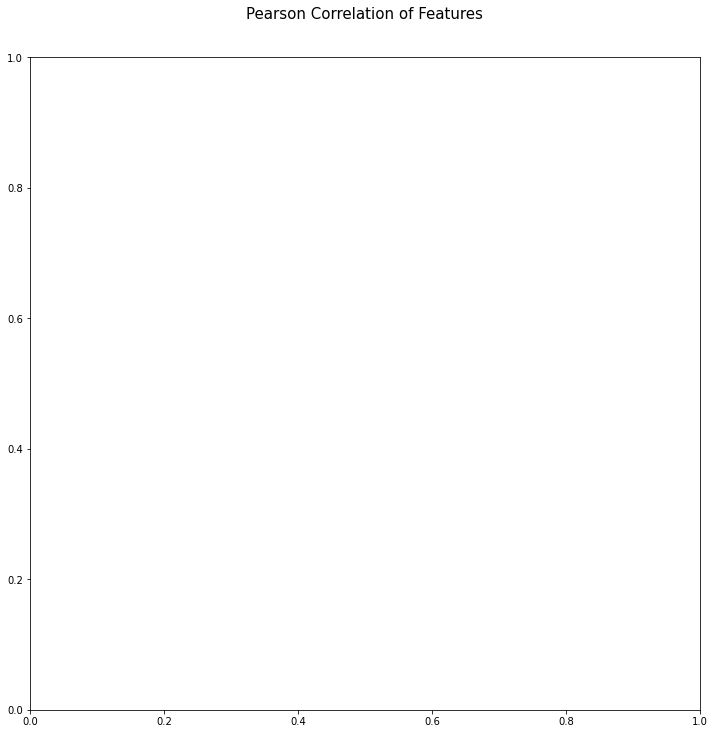

In [414]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_clean.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# **Decision Tree**

The objective of this assignment is for you to perform a complete implementation of a decision
tree classifier using your team’s project dataset.
0. Prior to building the ML model:

*   Split your data into testing and training.
*   Determine whether your label data needs to be discretized (if you have a numerical label).

**Exploring decision tree construction:**
Vary the following hyperparameters to build your decision tree classifier and report the evaluation metrics for both your training and testing data.

**1. Vary the criterion hyperparameter:**


a. Create a DT using the criterion parameter “gini” and report the accuracy,
precision, recall and F1 score.


b. Create a DT using the criterion parameter “entropy” and report the accuracy,
precision, recall and F1 score.

**2. Vary the splitter hyperparameter:**

a. Create a DT using the splitter parameter “best” and report the accuracy,
precision, recall and F1 score.

b. Create a DT using the splitter parameter “random” and report the accuracy,
precision, recall and F1 score.

**3. Vary the min_samples_split hyperparameter:**

a. Choose value 1 as your min_samples_split and report the accuracy, precision, recall and F1 score.


b. Choose value 2 as your min_samples_split and report the accuracy, precision, recall and F1 score.


**4. Vary the min_samples_leaf hyperparameter:**

a. Choose value 1 as your min_samples_leaf and report the accuracy, precision, recall and F1 score.

b. Choose value 2 as your min_samples_leaf and report the accuracy, precision, recall and F1 score.


**5. Vary the max_depth hyperparameter:**


a. Assign a limiting depth, e.g. 4, for our hyperparameter and report the accuracy, precision, recall and F1 score.


b. Assign a 2nd limiting depth, e.g. 8, for our hyperparameter and report the accuracy, precision, recall and F1 score.


**6. Hyperparameter overview:**

Provide a 2–3 paragraph summary of the results of your hyperparameter exploration. How did your ML model improve or depreciate with these variations?


# **Final Decision Tree & Evaluation**

**1. Which feature was used for the first split?**

**2. How many leaves are in the optimal classifier/ML model?**

**3. Produce a confusion_matrix and describe your ML model’s accuracy in terms of the number of true and false positives and negatives.** (Cailenys)

**4. Using scikit-learn’s classification_report method, generate the accuracy, precision, recall, and F1 score for your model and describe your ML model’s accuracy.** (Cailenys)


# **Visualize the structure of your final ML model:**


**5. Plot your tree. [Hint: using scikit-learn’s tree.plot_tree**

**6. Plot the decision surface of your tree using paired features. [See the following for help implementing:**
https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py]

# **Decision tree path:** 

**7. Provide a description of the potential path along your tree that a given new data point might take and provide its final result. The idea being that we want to know what decisions would be made along the way for that data point to end up at a particular label.**

# **ML model Accuracy**

Perform a comparison of our decision tree model vs. k-NN model: provide a comparison table of accuracy for your various DT ML models and your k-NN ML models. This will be a tool for comparison for you as a technician, but it will also serve as a communication tool to summarize to stakeholders what you tried, what worked best, and why.


# **Business Evaluation** (cailenys)


One of the key objectives of this course is to learn how to implement ML algorithms to tackle business problems and objectives. Please provide us with a complete scenario of how the results of your decision tree classifier might be used.

**Note:** you’ve previously considered some of these questions, the intent with reconsidering them is to iterate on our problem after obtaining results from our ML model:


**1. What might be the motivation for a decision tree classifier?**


**2. What is the “action” that should be taken given the results of this prediction?**

**3. Who is the best immediate person(s) to make use of the results of your prediction?**

**4. What is the potential payoff of this prediction for an organization? (e.g., costs or efficiency).**


**5. Do your ML models’ results change your problem? If so, how and why? If not, please explain.**